### Importing the libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,8
import os

### Importing the dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test_AbJTz2l (1).csv to test_AbJTz2l (1) (1).csv
Saving train_v9rqX0R (1).csv to train_v9rqX0R (1) (1).csv


In [ ]:
import io
df_train = pd.read_csv(io.BytesIO(uploaded["train_v9rqX0R (1).csv"]))
df_test = pd.read_csv(io.BytesIO(uploaded["test_AbJTz2l (1).csv"]))
df_train['Data'] = "Train"
df_test['Data'] = "Test"
df = pd.concat([df_train, df_test])
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Data
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,Train
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,Train
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,Train
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,Train
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,Train


### Data Preprocessing

#### Looking at the null values in the dataset

In [ ]:
features_with_null = [features for features in df.columns if df[features].isnull().sum() > 0]

for features in features_with_null:
    
    print(features, df[features].isnull().sum(), np.round(df[features].isnull().mean()*100, 4), '% missing values')

Item_Weight 2439 17.1712 % missing values
Outlet_Size 4016 28.2737 % missing values
Item_Outlet_Sales 5681 39.9958 % missing values


#### The dependent variable has missing values which are from the test dataset

#### Lets first impute the null values for the outlet size 

#### Basis for Imputation: The imputation will be done based on two factors:

#### 1. Looking at the mode of the outlet sizes in the different locations for the different types of outlets
#### 2. Comparing the sales of the outlets in the different locations

#### Assumption made: An outlet with particular size will have similar sales across different locations

In [ ]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Data
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,Train
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,Train
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,Train
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,Train
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,Train


In [ ]:
from scipy.stats import mode

df.pivot_table(values = 'Outlet_Size', columns = 'Outlet_Type', 
               aggfunc = lambda x: x.mode())

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [ ]:
size_df = df.pivot_table(index = ['Outlet_Location_Type', 'Outlet_Type','Outlet_Identifier'], 
               values = ['Outlet_Size'], aggfunc = lambda x: x.mode())

size_df

Outlet_Size
Outlet_Location_Type Outlet_Type       Outlet_Identifier            
Tier 1               Grocery Store     OUT019                  Small
                     Supermarket Type1 OUT046                  Small
                                       OUT049                 Medium
Tier 2               Supermarket Type1 OUT017                     []
                                       OUT035                  Small
                                       OUT045                     []
Tier 3               Grocery Store     OUT010                     []
                     Supermarket Type1 OUT013                   High
                     Supermarket Type2 OUT018                 Medium
                     Supermarket Type3 OUT027                 Medium

In [ ]:
df.pivot_table(index = ['Outlet_Location_Type', 'Outlet_Type','Outlet_Identifier'], 
               values = ['Outlet_Size'], aggfunc = 'count')

Outlet_Size
Outlet_Location_Type Outlet_Type       Outlet_Identifier             
Tier 1               Grocery Store     OUT019                     880
                     Supermarket Type1 OUT046                    1550
                                       OUT049                    1550
Tier 2               Supermarket Type1 OUT017                       0
                                       OUT035                    1550
                                       OUT045                       0
Tier 3               Grocery Store     OUT010                       0
                     Supermarket Type1 OUT013                    1553
                     Supermarket Type2 OUT018                    1546
                     Supermarket Type3 OUT027                    1559

#### Here we can see the null values for outlet size are present for outlet numbers 17, 45 and 10

#### Lets look at the sales of the outlets

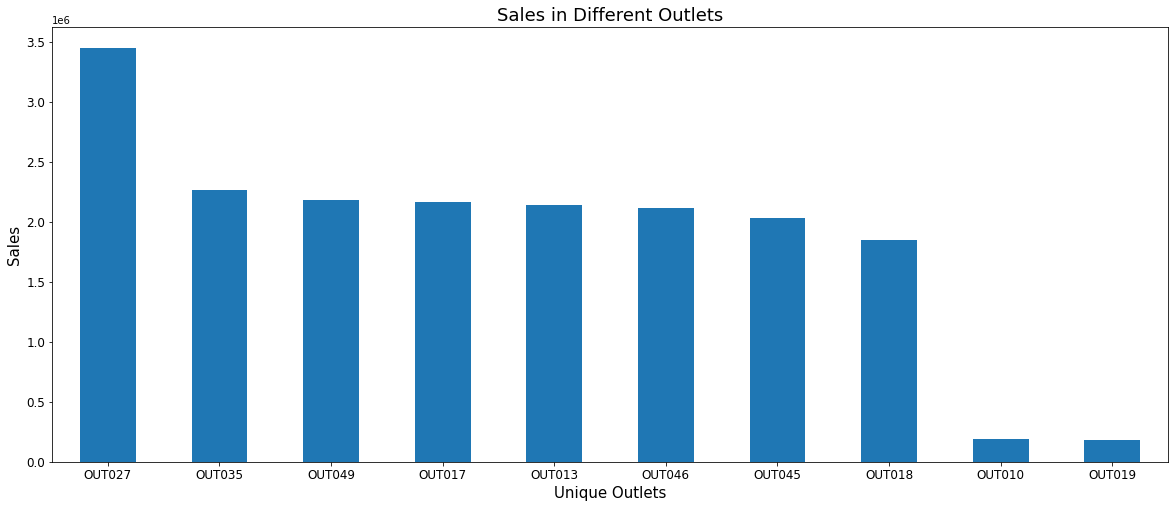

In [ ]:
plt.figure(figsize = (20,8))
df.groupby(['Outlet_Identifier'])['Item_Outlet_Sales'].sum().sort_values(ascending = False).plot.bar()
plt.xticks(fontsize = 12, rotation = 360) 
plt.yticks(fontsize = 12)
plt.xlabel("Unique Outlets", fontsize = 15)
plt.ylabel("Sales", fontsize = 15)
plt.title("Sales in Different Outlets", fontsize = 18)
plt.show()

#### Here we can see that outlet 10 and 19 have similar amounts of sales.Also the mode of outlet size for grocery stores  is small.  Outlet number 17 has similar sales with outlet number 49 which is medium in size and the mode for Supermarket Type 1 is medium as well. For outlet 45 also by the same logic I will impute size as medium.

#### Outlet 10 : Small
#### Outlet 17 and 45 : Medium

#### Imputing the null values for outlet size

In [ ]:
conditions = [df['Outlet_Identifier'] == "OUT010", df['Outlet_Identifier'] == "OUT017", df['Outlet_Identifier'] == "OUT045"]
values = ['Small', 'Medium', 'Medium']

df['Outlet_Size'] = np.where(df['Outlet_Size'].isnull(), np.select(conditions, values), df['Outlet_Size'])

In [ ]:
df['Outlet_Size'].value_counts()

Medium    7746
Small     4905
High      1553
Name: Outlet_Size, dtype: int64

In [ ]:
df.pivot_table(index = ['Outlet_Location_Type', 'Outlet_Type','Outlet_Identifier'], 
               values = ['Outlet_Size'], aggfunc = 'count')

Outlet_Size
Outlet_Location_Type Outlet_Type       Outlet_Identifier             
Tier 1               Grocery Store     OUT019                     880
                     Supermarket Type1 OUT046                    1550
                                       OUT049                    1550
Tier 2               Supermarket Type1 OUT017                    1543
                                       OUT035                    1550
                                       OUT045                    1548
Tier 3               Grocery Store     OUT010                     925
                     Supermarket Type1 OUT013                    1553
                     Supermarket Type2 OUT018                    1546
                     Supermarket Type3 OUT027                    1559

#### Here we can see that the null values have been imputed

#### Before imputing the item weights we need to clean other variables 

In [ ]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Data
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,Train
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,Train
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,Train
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,Train
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,Train


In [ ]:
df['Item_Fat_Content'].value_counts()

Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

#### Replacing the duplicates in the item fat column

In [ ]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].str.replace('LF','Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].str.replace('low fat','Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].str.replace('reg','Regular')

df['Item_Fat_Content'].value_counts()

Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64

#### Creating a new variable which will denote the type of product from the item identifier variable

In [ ]:
df['Item Category'] = df['Item_Identifier'].str[:2]

In [ ]:
df['Item Category'] = df['Item Category'].str.replace('FD','Food')
df['Item Category'] = df['Item Category'].str.replace('DR','Drinks')
df['Item Category'] = df['Item Category'].str.replace('NC','Non Consumable')

df['Item Category'].value_counts()

Food              10201
Non Consumable     2686
Drinks             1317
Name: Item Category, dtype: int64

#### Imputing the null values for item weight

#### Basis for imputation: The null values will be imputed based on the the type of the item. 
#### Assumption: Items of one type will have the same weight

In [ ]:
weight_df = df.pivot_table(values = 'Item_Weight', index = 'Item_Identifier')
weight_df.head()

,Item_Weight
Item_Identifier,
DRA12,11.600
DRA24,19.350
DRA59,8.270
DRB01,7.390
DRB13,6.115


In [ ]:
def impute_weight(data):
    Weight = data[0]
    Identifier = data[1]
    
    if pd.isnull(Weight):
        return weight_df['Item_Weight'][weight_df.index == Identifier]
    else:
        return Weight
    
print ('Orignal #missing: %d'%sum(df['Item_Weight'].isnull()))

df['Item_Weight'] = df[['Item_Weight','Item_Identifier']].apply(impute_weight,axis=1).astype(float)

print ('Final #missing: %d'%sum(df['Item_Weight'].isnull()))

Orignal #missing: 2439
Final #missing: 0


In [ ]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Data,Item Category
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,Train,Food
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,Train,Drinks
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,Train,Food
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,Train,Food
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,Train,Non Consumable


In [ ]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,14204.000000,14204.000000,14204.000000,14204.000000,8523.000000
mean,12.793380,0.065953,141.004977,1997.830681,2181.288914
std,4.651716,0.051459,62.086938,8.371664,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.710000,0.027036,94.012000,1987.000000,834.247400
50%,12.600000,0.054021,142.247000,1999.000000,1794.331000
75%,16.750000,0.094037,185.855600,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


#### Item Visibility has a minimum value of zero which is not possible in an outlet store.

#### Basis of imputation: The products with zero visibility will be replaced by the average visibility of the product types 

In [ ]:
visibility_df = df.pivot_table(index = 'Item_Identifier', values = 'Item_Visibility', aggfunc = 'mean')
visibility_df.head()

,Item_Visibility
Item_Identifier,
DRA12,0.034938
DRA24,0.045646
DRA59,0.133384
DRB01,0.079736
DRB13,0.006799


In [ ]:
def impute_visibility_mean(data):
    visibility = data[0]
    item = data[1]
    
    if visibility == 0:
        return visibility_df['Item_Visibility'][visibility_df.index == item]
    else:
        return visibility
    
print ('Original #zeros: %d'%sum(df['Item_Visibility'] == 0))

df['Item_Visibility'] = df[['Item_Visibility','Item_Identifier']].apply(impute_visibility_mean,axis = 1).astype(float)

print ('Final #zeros: %d'%sum(df['Item_Visibility'] == 0))

Original #zeros: 879
Final #zeros: 0


In [ ]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,14204.000000,14204.000000,14204.000000,14204.000000,8523.000000
mean,12.793380,0.069710,141.004977,1997.830681,2181.288914
std,4.651716,0.049728,62.086938,8.371664,1706.499616
min,4.555000,0.003575,31.290000,1985.000000,33.290000
25%,8.710000,0.031145,94.012000,1987.000000,834.247400
50%,12.600000,0.057194,142.247000,1999.000000,1794.331000
75%,16.750000,0.096930,185.855600,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


#### We can see that the visibility minimum has increased from 0


### Exploratory Data Analysis

#### Changing item type to item sub category, food type to item category

In [ ]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Data,Item Category
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,Train,Food
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,Train,Drinks
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,Train,Food
3,FDX07,19.20,Regular,0.017834,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,Train,Food
4,NCD19,8.93,Low Fat,0.009780,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,Train,Non Consumable


In [ ]:
df.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales', 'Data', 'Item Category'],
      dtype='object')

In [ ]:
df.columns = ['Item Id',	'Item Weight',	'Item Fat Content',	'Item Visibility',	'Item Sub Category',	'Item MRP',	'Outlet Id',	'Outlet Establishment Year',	'Outlet Size',	'Outlet Location Type',	'Outlet Type', 'Item Outlet Sales',	'Data',	'Item Category']

In [ ]:
df.head()

,Item Id,Item Weight,Item Fat Content,Item Visibility,Item Sub Category,Item MRP,Outlet Id,Outlet Establishment Year,Outlet Size,Outlet Location Type,Outlet Type,Item Outlet Sales,Data,Item Category
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,Train,Food
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,Train,Drinks
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,Train,Food
3,FDX07,19.20,Regular,0.017834,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,Train,Food
4,NCD19,8.93,Low Fat,0.009780,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,Train,Non Consumable


#### Lets look at the histogram of the outlet Sales

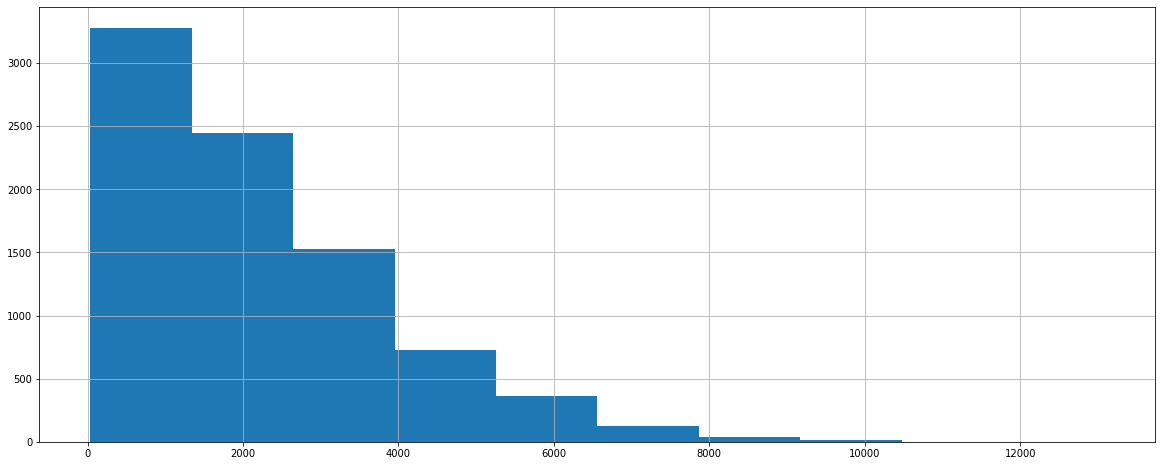

In [ ]:
plt.figure(figsize = (20,8))
df['Item Outlet Sales'].hist()

#### Here we can see that majority of the sales have been in the lower range but a few high sales more than $10,000 have increased the mean and pushed it towards the higher sales side.

#### We have three broad categories Food, Non Consumable and Drinks. Lets look at the number of products under each category

In [ ]:
df.groupby('Item Category')['Item Sub Category'].nunique().sort_values(ascending = False)

Item Category
Food              11
Non Consumable     3
Drinks             3
Name: Item Sub Category, dtype: int64

#### Finding the number of products under each sub category

In [ ]:
df.groupby(['Item Category','Item Sub Category'])['Item Id'].nunique()

Item Category   Item Sub Category    
Drinks          Dairy                     25
                Hard Drinks               40
                Soft Drinks               80
Food            Baking Goods             119
                Breads                    45
                Breakfast                 20
                Canned                   120
                Dairy                    100
                Frozen Foods             155
                Fruits and Vegetables    220
                Meat                      80
                Seafood                   10
                Snack Foods              220
                Starchy Foods             30
Non Consumable  Health and Hygiene        95
                Household                170
                Others                    30
Name: Item Id, dtype: int64

#### Lets look at the contribution of our Product Categories to our overall sales

In [ ]:
df.head()

,Item Id,Item Weight,Item Fat Content,Item Visibility,Item Sub Category,Item MRP,Outlet Id,Outlet Establishment Year,Outlet Size,Outlet Location Type,Outlet Type,Item Outlet Sales,Data,Item Category
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,Train,Food
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,Train,Drinks
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,Train,Food
3,FDX07,19.20,Regular,0.017834,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,Train,Food
4,NCD19,8.93,Low Fat,0.009780,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,Train,Non Consumable


In [ ]:
category_sales = pd.DataFrame(df.groupby('Item Category')['Item Outlet Sales'].sum().astype(int))
category_sales['Percentage of Total'] = category_sales['Item Outlet Sales']/category_sales['Item Outlet Sales'].sum()*100
category_sales.sort_values(by = 'Percentage of Total', ascending = False)

,Item Outlet Sales,Percentage of Total
Item Category,,
Food,13569044,72.986679
Non Consumable,3426211,18.429284
Drinks,1595869,8.584037


Text(0.5, 1.0, 'Total Sales of Product Categories')

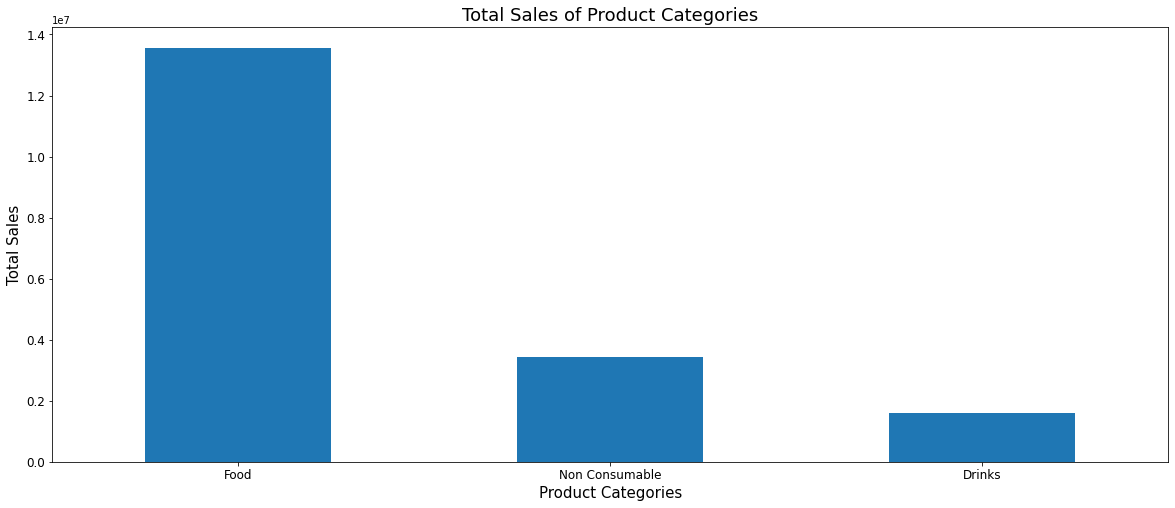

In [ ]:
plt.figure(figsize = (20,8))
df.groupby('Item Category')['Item Outlet Sales'].sum().sort_values(ascending = False).plot.bar()
plt.xticks(rotation = 360, fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Product Categories", fontsize = 15)
plt.ylabel("Total Sales", fontsize = 15)
plt.title("Total Sales of Product Categories", fontsize = 18)

#### Here we can see that the food products is giving the highest revenue out of the total product types

#### Lets look at the contribution of the product sub categories 

In [ ]:
sub_category_sales = pd.DataFrame(df.groupby('Item Sub Category')['Item Outlet Sales'].sum().astype(int))
sub_category_sales['Percentage of Total'] = sub_category_sales['Item Outlet Sales']/sub_category_sales['Item Outlet Sales'].sum()*100
sub_category_sales['Number of Items'] = df.groupby(['Item Sub Category'])['Item Id'].nunique()
sub_category_sales['Sales per item'] = (sub_category_sales['Item Outlet Sales']/sub_category_sales['Number of Items']).astype(int)
sub_category_sales.sort_values(by = 'Percentage of Total', ascending = False)

,Item Outlet Sales,Percentage of Total,Number of Items,Sales per item
Item Sub Category,,,,
Fruits and Vegetables,2820059,15.168851,220,12818
Snack Foods,2732786,14.699417,220,12421
Household,2055493,11.056317,170,12091
Frozen Foods,1825734,9.820464,155,11778
Dairy,1522594,8.189900,125,12180
Canned,1444151,7.767962,120,12034
Baking Goods,1265525,6.807148,119,10634
Health and Hygiene,1045200,5.622040,95,11002
Meat,917565,4.935502,80,11469


Text(0.5, 1.0, 'Total Sales of Product Sub Categories')

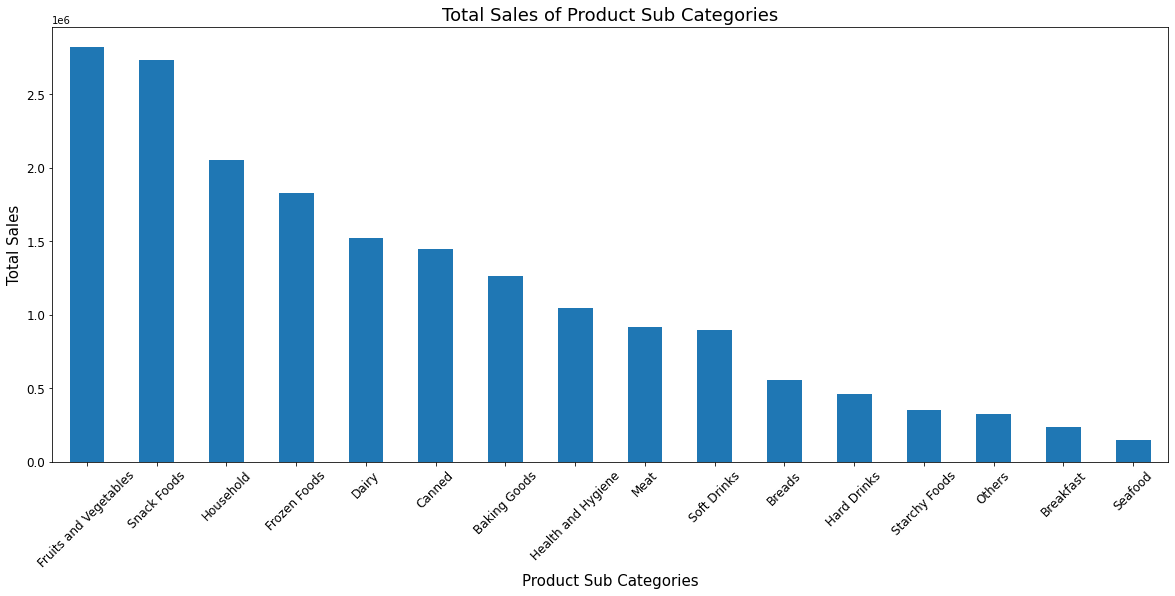

In [ ]:
plt.figure(figsize = (20,8))
df.groupby('Item Sub Category')['Item Outlet Sales'].sum().sort_values(ascending = False).plot.bar()
plt.xticks(rotation = 45,fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Product Sub Categories", fontsize = 15)
plt.ylabel("Total Sales", fontsize = 15)
plt.title("Total Sales of Product Sub Categories", fontsize = 18)

#### Here we can seee that Fruits and Vegetables, Snack Foods and Households are the top three revenue generating product sub categories

#### Lets find out within each category how the sub categories are doing?

In [ ]:
sub_category_sales_within_catgories = pd.DataFrame(df.groupby(['Item Category','Item Sub Category'])['Item Outlet Sales'].sum().astype(int))
sub_category_sales_within_catgories['Percentage of Total'] = sub_category_sales_within_catgories['Item Outlet Sales']/sub_category_sales_within_catgories.groupby('Item Category')['Item Outlet Sales'].sum()*100
sub_category_sales_within_catgories

Item Outlet Sales  Percentage of Total
Item Category  Item Sub Category                                            
Drinks         Dairy                             245178            15.363301
               Hard Drinks                       457793            28.686144
               Soft Drinks                       892897            55.950555
Food           Baking Goods                     1265525             9.326563
               Breads                            553237             4.077201
               Breakfast                         232298             1.711971
               Canned                           1444151            10.642987
               Dairy                            1277415             9.414189
               Frozen Foods                     1825734            13.455146
               Fruits and Vegetables            2820059            20.783041
               Meat                              917565             6.762196
               Seafood                           148868             1.097115
               Snack Foods                      2732786            20.139864
               Starchy Foods                     351401             2.589727
Non Consumable Health and Hygiene               1045200            30.506011
               Household                        2055493            59.993199
               Others                            325517             9.500790

#### Here we can spot the top selling items under each category 
#### Under Drinks Soft Drinks generates 55% share of revenue
#### Under Food Fruits and Vegetables and Snack Foods together contribute 40% of the revenue 
#### Under Non Consumable Health and Hygiene and Household contributes 89%

#### Lets look at the number of product with fat content

In [ ]:
df.groupby(['Item Category','Item Fat Content'])['Item Id'].nunique().sort_values(ascending = False)

Item Category   Item Fat Content
Food            Low Fat             580
                Regular             539
Non Consumable  Low Fat             295
Drinks          Low Fat             133
                Regular              12
Name: Item Id, dtype: int64

#### Here we can see that non consumable items have low fat conten which does not make sense. So we will change this to non edible

In [ ]:
df.loc[df['Item Category'] == 'Non Consumable', 'Item Fat Content'] = "Non Edible"

In [ ]:
df.groupby(['Item Sub Category','Item Fat Content'])['Item Id'].nunique().sort_values(ascending = False)

Item Sub Category      Item Fat Content
Household              Non Edible          170
Snack Foods            Low Fat             126
Fruits and Vegetables  Low Fat             119
                       Regular             101
Health and Hygiene     Non Edible           95
Snack Foods            Regular              94
Frozen Foods           Low Fat              79
Dairy                  Low Fat              76
Frozen Foods           Regular              76
Soft Drinks            Low Fat              68
Baking Goods           Regular              60
Canned                 Low Fat              60
                       Regular              60
Baking Goods           Low Fat              59
Meat                   Regular              49
Dairy                  Regular              49
Hard Drinks            Low Fat              40
Meat                   Low Fat              31
Others                 Non Edible           30
Breads                 Low Fat              24
                    

#### Lets look at the sales of the products based on the fat content

Text(0.5, 1.0, 'Total Sales of Product Categories and Fat Content')

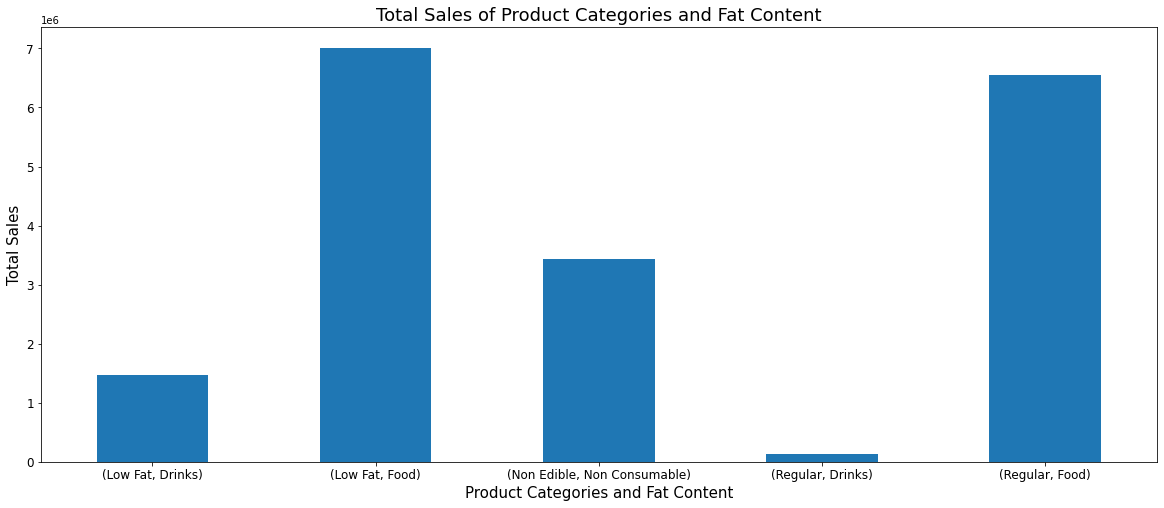

In [ ]:
plt.figure(figsize = (20,8))
df.groupby(['Item Fat Content','Item Category'])['Item Outlet Sales'].sum().astype(int).plot(kind = 'bar')
plt.xticks(rotation = 360, fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Product Categories and Fat Content", fontsize = 15)
plt.ylabel("Total Sales", fontsize = 15)
plt.title("Total Sales of Product Categories and Fat Content", fontsize = 18)

#### Low fat drinks are selling more than regular drinks

#### Is the choice of fat content by customers dependent on the tier of city

In [ ]:
df.groupby(['Outlet Location Type','Item Fat Content'])['Item Id'].count()

Outlet Location Type  Item Fat Content
Tier 1                Low Fat             1822
                      Non Edible           755
                      Regular             1403
Tier 2                Low Fat             2125
                      Non Edible           877
                      Regular             1639
Tier 3                Low Fat             2552
                      Non Edible          1054
                      Regular             1977
Name: Item Id, dtype: int64

#### Lets visualize this in a plot

Text(0.5, 1.0, 'Number of items sold of each fat type')

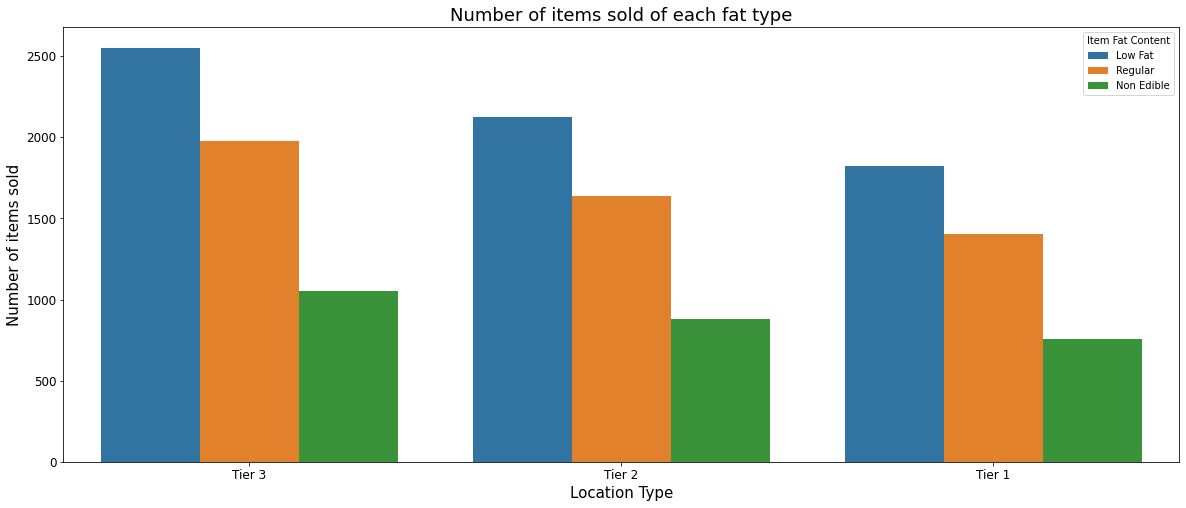

In [ ]:
plt.figure(figsize = (20,8))
sb.countplot(x = 'Outlet Location Type', hue = 'Item Fat Content', data = df, order = df['Outlet Location Type'].value_counts().index)
plt.xticks(fontsize = 12) 
plt.yticks(fontsize = 12)
plt.xlabel("Location Type", fontsize = 15)
plt.ylabel("Number of items sold", fontsize = 15)
plt.title("Number of items sold of each fat type", fontsize = 18)

#### We can see in each location low fat items are selling more in all the three tiers. The overall sales also is highest in tier 3

#### Lets look at the number of stores we have in each tier

In [ ]:
df.groupby(['Outlet Location Type'])['Outlet Id'].count()

Outlet Location Type
Tier 1    3980
Tier 2    4641
Tier 3    5583
Name: Outlet Id, dtype: int64

Text(0.5, 1.0, 'Number of Stores in each Location')

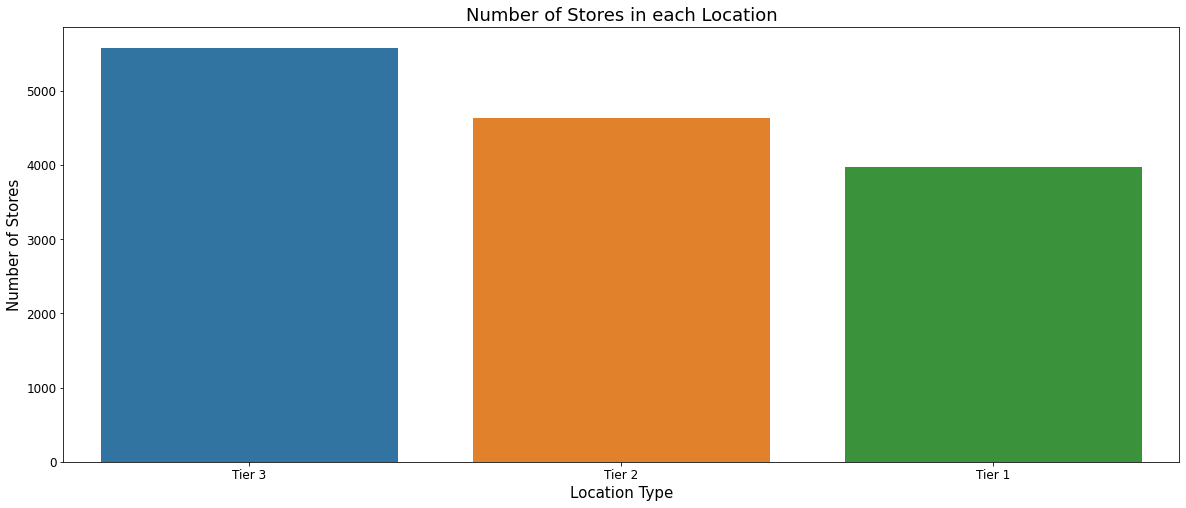

In [ ]:
plt.figure(figsize = (20,8))
sb.countplot(x = 'Outlet Location Type', data = df, order = df['Outlet Location Type'].value_counts().index)
plt.xticks(fontsize = 12) 
plt.yticks(fontsize = 12)
plt.xlabel("Location Type", fontsize = 15)
plt.ylabel("Number of Stores", fontsize = 15)
plt.title("Number of Stores in each Location", fontsize = 18)

In [ ]:
tier_sales = pd.DataFrame(df.groupby(['Outlet Location Type'])['Item Outlet Sales'].sum().astype(int))
tier_sales['Percentage of Total'] = tier_sales['Item Outlet Sales']/tier_sales['Item Outlet Sales'].sum()*100
tier_sales

,Item Outlet Sales,Percentage of Total
Outlet Location Type,,
Tier 1,4482059,24.108596
Tier 2,6472313,34.813995
Tier 3,7636752,41.077409


#### Looking at the number of stores of different types in each tier

In [ ]:
df.groupby(['Outlet Location Type','Outlet Type'])['Outlet Id'].count()

Outlet Location Type  Outlet Type      
Tier 1                Grocery Store         880
                      Supermarket Type1    3100
Tier 2                Supermarket Type1    4641
Tier 3                Grocery Store         925
                      Supermarket Type1    1553
                      Supermarket Type2    1546
                      Supermarket Type3    1559
Name: Outlet Id, dtype: int64

Text(0.5, 1.0, 'Number of Stores of each type')

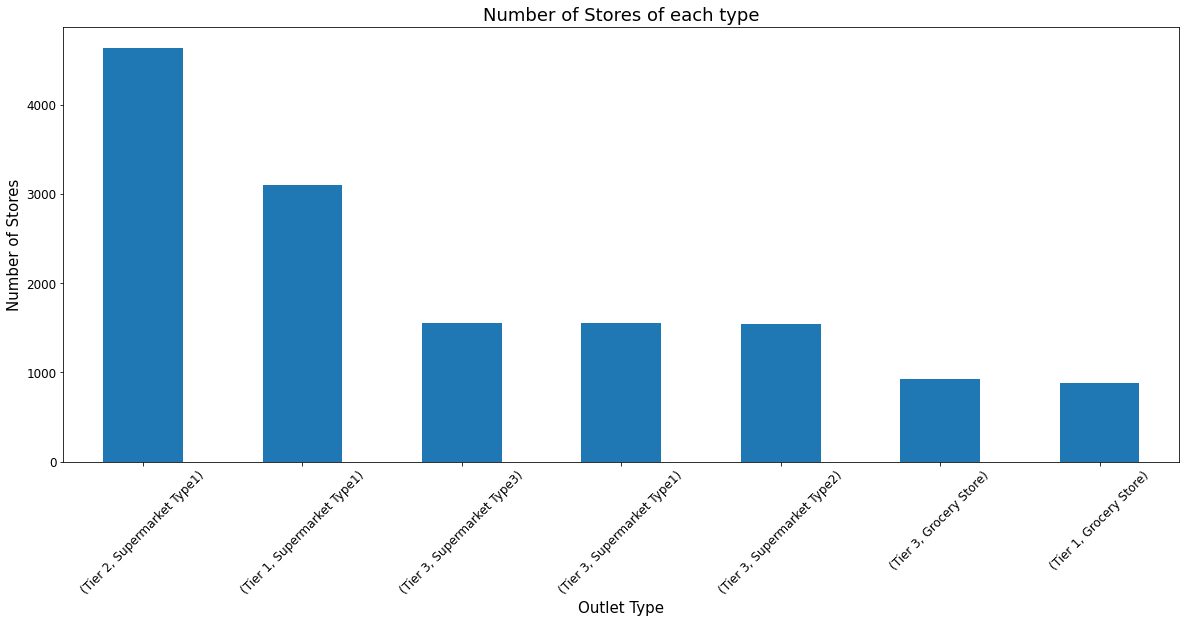

In [ ]:
plt.figure(figsize = (20,8))
df.groupby(['Outlet Location Type','Outlet Type'])['Outlet Type'].count().sort_values(ascending = False).plot.bar()
plt.xticks(rotation = 45)
plt.xticks(fontsize = 12) 
plt.yticks(fontsize = 12)
plt.xlabel("Outlet Type", fontsize = 15)
plt.ylabel("Number of Stores", fontsize = 15)
plt.title("Number of Stores of each type", fontsize = 18)

In [ ]:
outlet_type_sales = pd.DataFrame(df.groupby(['Outlet Location Type','Outlet Type'])['Item Outlet Sales'].sum()).astype(int)
outlet_type_sales['Percentage of Total'] = outlet_type_sales['Item Outlet Sales']/outlet_type_sales['Item Outlet Sales'].sum()*100
outlet_type_sales

Item Outlet Sales  Percentage of Total
Outlet Location Type Outlet Type                                              
Tier 1               Grocery Store                 179694             0.966558
                     Supermarket Type1            4302364            23.142035
Tier 2               Supermarket Type1            6472313            34.813999
Tier 3               Grocery Store                 188340             1.013064
                     Supermarket Type1            2142663            11.525195
                     Supermarket Type2            1851822             9.960787
                     Supermarket Type3            3453926            18.578362

Text(0.5, 1.0, 'Sales of Stores of each type')

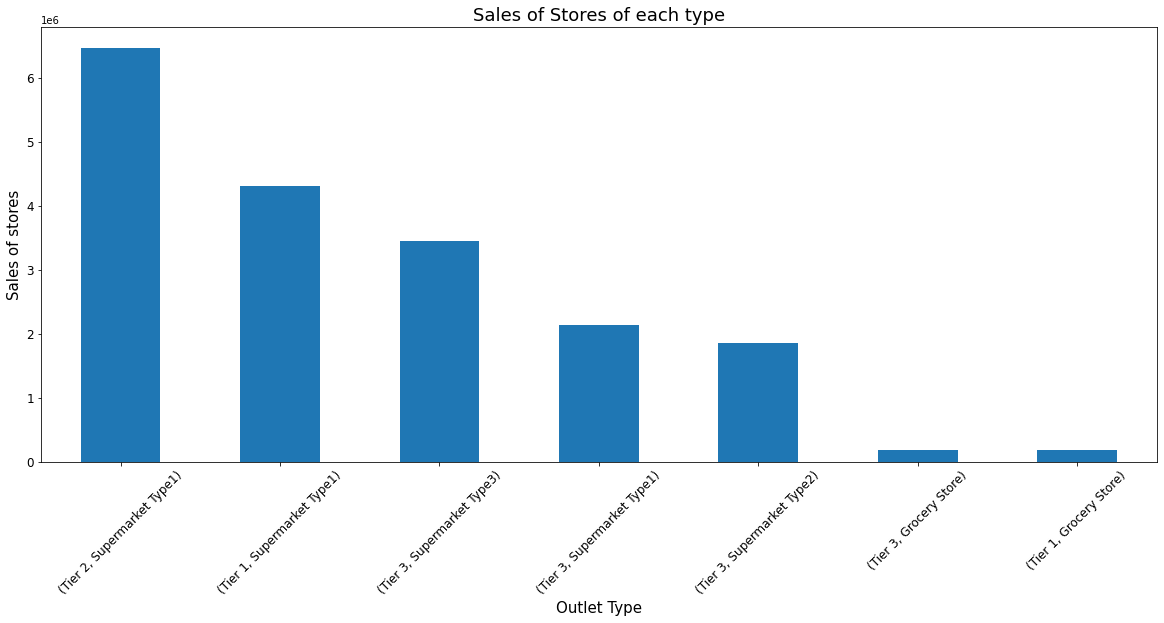

In [ ]:
outlet_type_sales['Item Outlet Sales'].sort_values(ascending = False).plot.bar()
plt.xticks(rotation = 45)
plt.xticks(fontsize = 12) 
plt.yticks(fontsize = 12)
plt.xlabel("Outlet Type", fontsize = 15)
plt.ylabel("Sales of stores", fontsize = 15)
plt.title("Sales of Stores of each type", fontsize = 18)

#### Combining the pivot table and the sales chart we can see that: 

#### The number of stores in a particular type of a particular location is proportional to the sales

#### Looking at the number of outlet sizes

Text(0.5, 1.0, 'Number of Stores of each size')

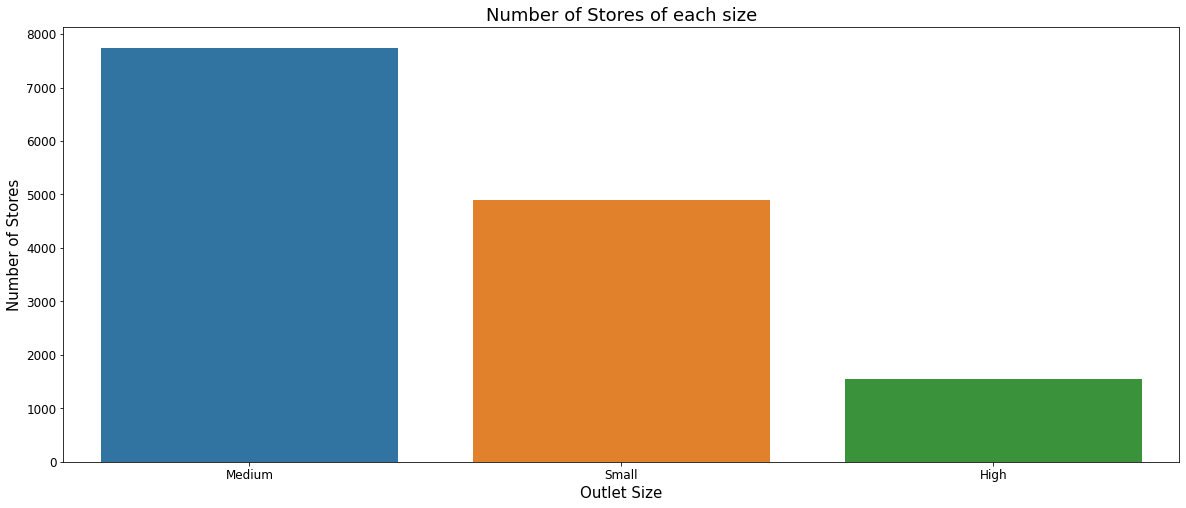

In [ ]:
plt.figure(figsize = (20,8))
sb.countplot(df['Outlet Size'])
plt.xticks(fontsize = 12) 
plt.yticks(fontsize = 12)
plt.xlabel("Outlet Size", fontsize = 15)
plt.ylabel("Number of Stores", fontsize = 15)
plt.title("Number of Stores of each size", fontsize = 18)

#### Looking at the sales contribution of each size type

In [ ]:
outlet_size_sales = pd.DataFrame(df.groupby(['Outlet Location Type','Outlet Size'])['Item Outlet Sales'].sum()).astype(int)
outlet_size_sales['Percentage of Total'] = outlet_size_sales['Item Outlet Sales']/outlet_size_sales['Item Outlet Sales'].sum()*100
outlet_size_salesoutlet_size_sales = pd.DataFrame(df.groupby(['Outlet Location Type','Outlet Size'])['Item Outlet Sales'].sum()).astype(int)
outlet_size_sales['Percentage of Total'] = outlet_size_sales['Item Outlet Sales']/outlet_size_sales['Item Outlet Sales'].sum()*100
outlet_size_sales

Item Outlet Sales  Percentage of Total
Outlet Location Type Outlet Size                                        
Tier 1               Medium                 2183969            11.747377
                     Small                  2298089            12.361218
Tier 2               Medium                 4204190            22.613967
                     Small                  2268122            12.200028
Tier 3               High                   2142663            11.525195
                     Medium                 5305748            28.539150
                     Small                   188340             1.013064

#### Here we can see that the size of the stores is not proportional to sales. Lets include the outlet type into the analysis

In [ ]:
outlet_size_type_sales = pd.DataFrame(df.groupby(['Outlet Location Type','Outlet Size','Outlet Type'])['Item Outlet Sales'].sum()).astype(int)
outlet_size_type_sales['Percentage of Total'] = outlet_size_type_sales['Item Outlet Sales']/outlet_size_type_sales['Item Outlet Sales'].sum()*100
outlet_size_type_sales

Item Outlet Sales  Percentage of Total
Outlet Location Type Outlet Size Outlet Type                                              
Tier 1               Medium      Supermarket Type1            2183969            11.747377
                     Small       Grocery Store                 179694             0.966558
                                 Supermarket Type1            2118395            11.394660
Tier 2               Medium      Supermarket Type1            4204190            22.613967
                     Small       Supermarket Type1            2268122            12.200028
Tier 3               High        Supermarket Type1            2142663            11.525195
                     Medium      Supermarket Type2            1851822             9.960787
                                 Supermarket Type3            3453926            18.578363
                     Small       Grocery Store                 188340             1.013064

Text(0.5, 1.0, 'Sales VS Outlet, Size, Type and Location')

<Figure size 1440x576 with 0 Axes>

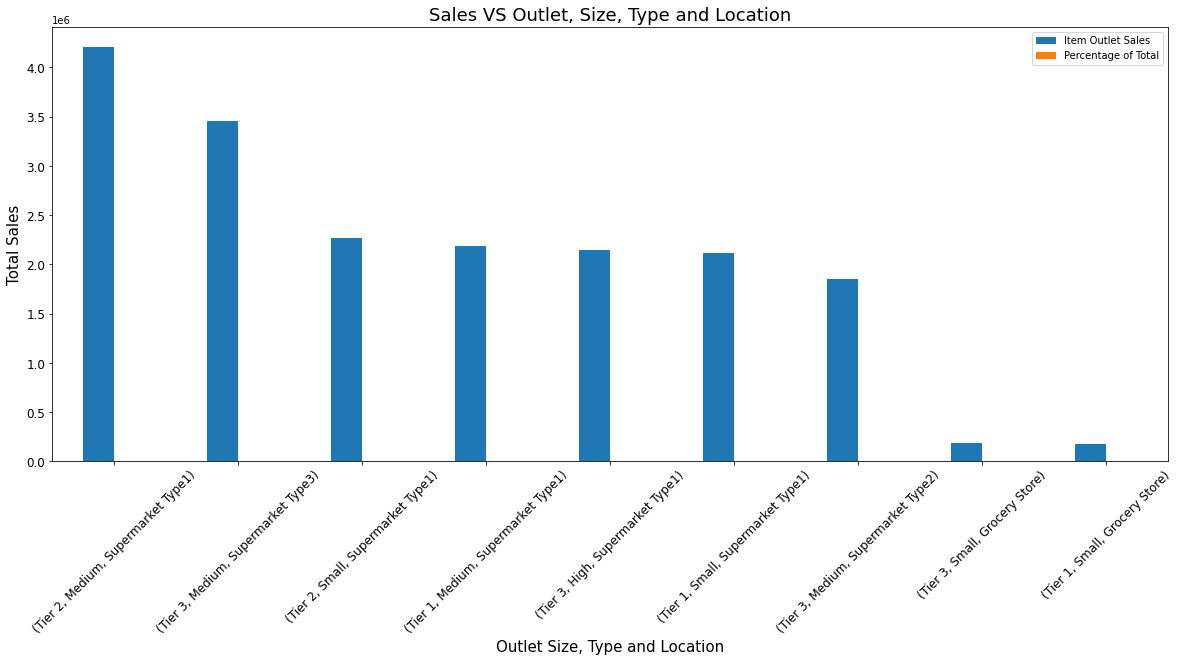

In [ ]:
plt.figure(figsize = (20,8))
outlet_size_type_sales.sort_values(ascending = False, by = 'Item Outlet Sales').plot(kind = 'bar')
plt.xticks(fontsize = 12, rotation = 45) 
plt.yticks(fontsize = 12)
plt.xlabel("Outlet Size, Type and Location", fontsize = 15)
plt.ylabel("Total Sales", fontsize = 15)
plt.title("Sales VS Outlet, Size, Type and Location", fontsize = 18)

#### We can see that the same medium sized supermarket type 1 is doing differently in tier 1 and 2

In [ ]:
df.groupby(['Outlet Location Type','Outlet Size','Outlet Type'])['Outlet Id'].count()

Outlet Location Type  Outlet Size  Outlet Type      
Tier 1                Medium       Supermarket Type1    1550
                      Small        Grocery Store         880
                                   Supermarket Type1    1550
Tier 2                Medium       Supermarket Type1    3091
                      Small        Supermarket Type1    1550
Tier 3                High         Supermarket Type1    1553
                      Medium       Supermarket Type2    1546
                                   Supermarket Type3    1559
                      Small        Grocery Store         925
Name: Outlet Id, dtype: int64

#### This can be attributed to the number of stores in the two tiers

#### Lets look at the sales of the outlets for each location type and size

In [ ]:
items_sold = pd.DataFrame(df.groupby(['Outlet Type','Outlet Size','Outlet Location Type'])['Item Outlet Sales'].sum().astype(int))
items_sold['Percentage of Total'] = items_sold['Item Outlet Sales']/items_sold['Item Outlet Sales'].sum()*100
items_sold['Number of stores'] = df.groupby(['Outlet Type','Outlet Size'])['Outlet Id'].count()
items_sold['Sales per store'] = items_sold['Item Outlet Sales']/items_sold['Number of stores']
items_sold.sort_values(ascending = False, by = 'Number of stores')

Item Outlet Sales  ...  Sales per store
Outlet Type       Outlet Size Outlet Location Type                     ...                 
Supermarket Type1 Medium      Tier 1                          2183969  ...       470.581556
                              Tier 2                          4204190  ...       905.880198
                  Small       Tier 1                          2118395  ...       683.353226
                              Tier 2                          2268122  ...       731.652258
Grocery Store     Small       Tier 1                           179694  ...        99.553463
                              Tier 3                           188340  ...       104.343490
Supermarket Type3 Medium      Tier 3                          3453926  ...      2215.475305
Supermarket Type1 High        Tier 3                          2142663  ...      1379.692853
Supermarket Type2 Medium      Tier 3                          1851822  ...      1197.815006

[9 rows x 4 columns]

#### How is supermarket type 3 with medium size getting more revenue from a high sized supermarket type 1 with both havin comparable number of stores and being more same Tier 3?


#### Lets shorlist a dataframe for only tier 3

In [ ]:
df_tier_3 = df[df['Outlet Location Type'] == "Tier 3"]

#### Reasoning: Maybe the MRP of the products sold are different. So lets look at the mrp of the products sold in these supermarkets

In [ ]:
pivot = pd.DataFrame(df_tier_3.pivot_table(index = ['Outlet Type', 'Outlet Size'], values = ['Item MRP','Item Outlet Sales'], 
                               aggfunc = {'mean'})).astype(int)

pivot

,,Item MRP,Item Outlet Sales
,,mean,mean
Outlet Type,Outlet Size,,
Grocery Store,Small,141,339
Supermarket Type1,High,141,2298
Supermarket Type2,Medium,141,1995
Supermarket Type3,Medium,141,3694


#### Here we can see that the average sales for Supermarket Type 3 is the highest and the MRP is also the least. So maybe because of the pricing a medium sized supermarket is getting more sales than high sized one.

#### Lets see whether visibility of the products play a role behind this

In [ ]:
vis_outlet = pd.DataFrame(df_tier_3.groupby(['Outlet Type','Outlet Size'])['Item Visibility','Item MRP'].mean().astype(float))
vis_outlet

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,,Item Visibility,Item MRP
Outlet Type,Outlet Size,,
Grocery Store,Small,0.105148,141.159742
Supermarket Type1,High,0.064122,141.128428
Supermarket Type2,Medium,0.064272,141.000899
Supermarket Type3,Medium,0.063780,141.012347


<Figure size 1440x576 with 0 Axes>

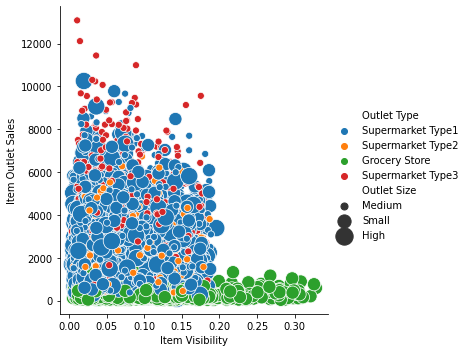

In [ ]:
plt.figure(figsize = (20,8))
sb.relplot(x = "Item Visibility", y = "Item Outlet Sales", hue = "Outlet Type", data = df, size = "Outlet Size", sizes = (300, 50));

#### Here we can see that the visibility of the grocery stores is not corresponding to sales

#### This shows the relation between sales and price of the products across the different supermarket types

#### Looking at the sales of products across the years of Establishment

<Figure size 1440x576 with 0 Axes>

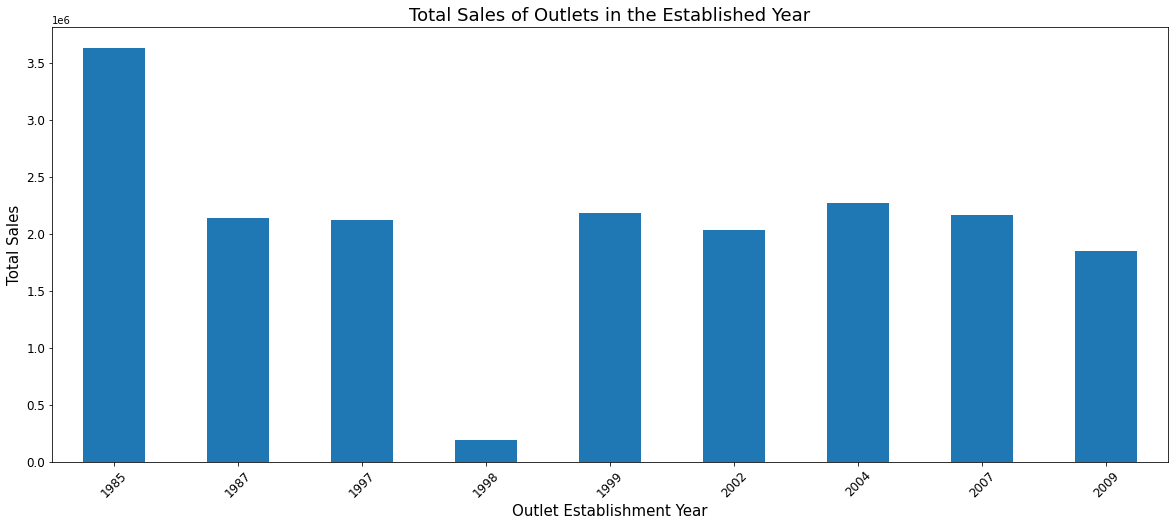

<Figure size 1440x576 with 0 Axes>

In [ ]:
plt.figure(figsize = (20,8))
df.groupby('Outlet Establishment Year')['Item Outlet Sales'].sum().plot.bar()
plt.xticks(rotation = 45, fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Outlet Establishment Year", fontsize = 15)
plt.ylabel("Total Sales", fontsize = 15)
plt.title("Total Sales of Outlets in the Established Year", fontsize = 18)
plt.figure('f')

#### Why was there such a drastic fall in 1998?

Text(0.5, 1.0, 'Total Number of Outlets Established in Each Year')

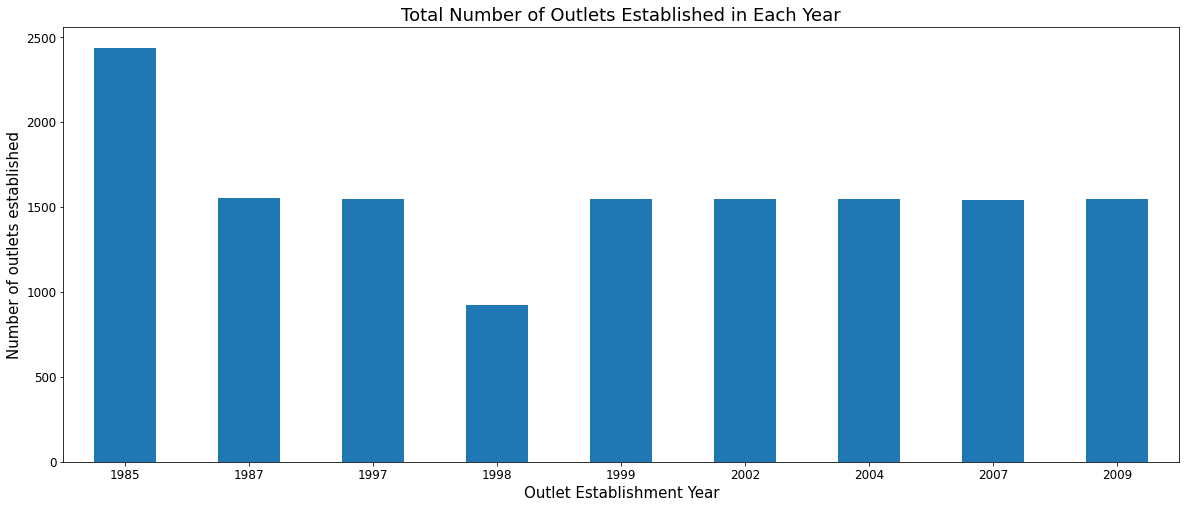

In [ ]:
plt.figure(figsize = (20,8))
df.groupby('Outlet Establishment Year')['Outlet Id'].count().plot.bar()
plt.xticks(rotation = 360, fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Outlet Establishment Year", fontsize = 15)
plt.ylabel("Number of outlets established", fontsize = 15)
plt.title("Total Number of Outlets Established in Each Year", fontsize = 18)

#### We can see a drop in the number of outlets which can be a reason of reduced sales

#### Creating a new variable which will show the number of years of the outlet store

In [ ]:
df['Outlet Tenure'] = 2013 - df['Outlet Establishment Year']
df.head()

,Item Id,Item Weight,Item Fat Content,Item Visibility,Item Sub Category,Item MRP,Outlet Id,Outlet Establishment Year,Outlet Size,Outlet Location Type,Outlet Type,Item Outlet Sales,Data,Item Category,Outlet Tenure
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,Train,Food,14
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,Train,Drinks,4
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,Train,Food,14
3,FDX07,19.20,Regular,0.017834,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,Train,Food,15
4,NCD19,8.93,Non Edible,0.009780,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,Train,Non Consumable,26


#### Lets see if newer stores are getting more sales

Text(0.5, 1.0, 'Total Sales VS Tenure')

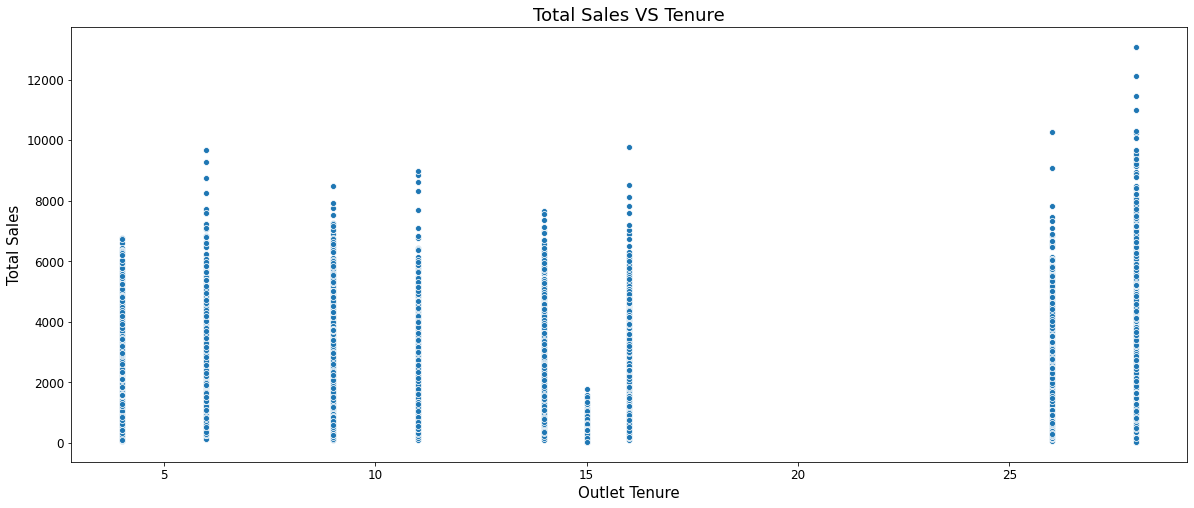

In [ ]:
plt.figure(figsize = (20,8))
sb.scatterplot(x = "Outlet Tenure", y = "Item Outlet Sales", data = df)
plt.xticks(rotation = 360, fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Outlet Tenure", fontsize = 15)
plt.ylabel("Total Sales", fontsize = 15)
plt.title("Total Sales VS Tenure", fontsize = 18)

#### From here no relationship can be deduced

### Findings from EDA:

#### 1. The distribution of sales right skewed which means mostly the sales figure was below 4000 but because of certain outlier sales above 10,000 the distribution mean has shifted towards the right.

#### 2. We have 3 Categories of Products Food, Non Consumable and Drinks.Under food we have 11 sub categories and 3 for each of Food and Non Consumable.

#### 3. Under Food we have 580 Low Fat items and 539 Regular Items. For Non Consumable there is only 295 Low Fat Items. For Drinks there are 133 Low Fat Items and 12 Regular Items.

#### 4. Food Category, Non Consumable and Drinks account for 73%, 18.5% and 8.5% of the total revenue generated

#### 5. Within Food, Fruits and Vegetables and Starchy Foods contributed 20% each. For Drinks, Soft Drinks and Hard Drinks contributed 55% and 28% respectively. For Non Consumables Household items and Health items contributed 59% and 30% resepectively.

#### 6. In terms of overall revenue Fruits and Vegetables, Snack Foods and Households contributes the highest with 15%, 14% and 11% of total revenue.

#### 7. Drinks with low fat are selling more compared to regular drinks.

#### 8. Tier 3 with 3350 stores contributes 41% of the total revenue. Tier 2 and 1 has 2785 and 2388 stores and contributes 35% and 24% respectively of the total profit.

#### 9. The number of items sold and revenue gained is high for low fat compared to regular items across all the three tiers

#### 10. Supermarket Type 1 has the highest number of stores across all the tiers. The number of stores of a particular type in a location is proportional to sales. This can be seen by looking at the sales of Supermarket Type 1 in Tier 1 and 2 which have the highest number of stores and also contributes 23% and 34% respectively.

#### 11. The tier 3 medium sized outlets are contributing 28% of total revenue which is more than the high sized outlets in the same tier. They are also generating more revenue compared to small or medium sized outlets in other tiers.

#### 12. Same supermarket type 1 is doing diffferently in two tiers 1 and 2. This can be attributed to the number of mid sized stores in the two tiers.

#### 13. Supermarket Type 3 having medium sized outlets is generating more revenue than a high sized outlets of Supermarket Type 1 in tier 3. One reason is the average MRP of the products is lower which incentivizes customers to buy more.

#### 14. The sales from outlets established in the year 1998 say a fall in the total sales. This can be attributed to the reduced number of stores established in that year

### Modelling

In [ ]:
pd.set_option('display.max_columns', 500)

In [ ]:
df['Item Visibility Ratio'] = df['Item Visibility']/(df['Item Visibility'].mean())
df.head()

,Item Id,Item Weight,Item Fat Content,Item Visibility,Item Sub Category,Item MRP,Outlet Id,Outlet Establishment Year,Outlet Size,Outlet Location Type,Outlet Type,Item Outlet Sales,Data,Item Category,Outlet Tenure,Item Visibility Ratio
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,Train,Food,14,0.230202
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,Train,Drinks,4,0.276550
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,Train,Food,14,0.240427
3,FDX07,19.20,Regular,0.017834,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,Train,Food,15,0.255838
4,NCD19,8.93,Non Edible,0.009780,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,Train,Non Consumable,26,0.140294


In [ ]:
df = df.drop(['Outlet Id','Item Id'], axis = 1)
df.head()

,Item Weight,Item Fat Content,Item Visibility,Item Sub Category,Item MRP,Outlet Establishment Year,Outlet Size,Outlet Location Type,Outlet Type,Item Outlet Sales,Data,Item Category,Outlet Tenure,Item Visibility Ratio
0,9.30,Low Fat,0.016047,Dairy,249.8092,1999,Medium,Tier 1,Supermarket Type1,3735.1380,Train,Food,14,0.230202
1,5.92,Regular,0.019278,Soft Drinks,48.2692,2009,Medium,Tier 3,Supermarket Type2,443.4228,Train,Drinks,4,0.276550
2,17.50,Low Fat,0.016760,Meat,141.6180,1999,Medium,Tier 1,Supermarket Type1,2097.2700,Train,Food,14,0.240427
3,19.20,Regular,0.017834,Fruits and Vegetables,182.0950,1998,Small,Tier 3,Grocery Store,732.3800,Train,Food,15,0.255838
4,8.93,Non Edible,0.009780,Household,53.8614,1987,High,Tier 3,Supermarket Type1,994.7052,Train,Non Consumable,26,0.140294


In [ ]:
df['Item Fat Content'] = df['Item Fat Content'].map({'Non Edible': 0,'Low Fat': 1, 'Regular': 2})

In [ ]:
df['Outlet Location Type'] = df['Outlet Location Type'].map({'Tier 1': 0,'Tier 2': 1, 'Tier 3': 2})

In [ ]:
df['Outlet Size'] = df['Outlet Size'].map({'Small': 0,'Medium': 1, 'High': 2})

In [ ]:
df.head()

,Item Weight,Item Fat Content,Item Visibility,Item Sub Category,Item MRP,Outlet Establishment Year,Outlet Size,Outlet Location Type,Outlet Type,Item Outlet Sales,Data,Item Category,Outlet Tenure,Item Visibility Ratio
0,9.30,1,0.016047,Dairy,249.8092,1999,1,0,Supermarket Type1,3735.1380,Train,Food,14,0.230202
1,5.92,2,0.019278,Soft Drinks,48.2692,2009,1,2,Supermarket Type2,443.4228,Train,Drinks,4,0.276550
2,17.50,1,0.016760,Meat,141.6180,1999,1,0,Supermarket Type1,2097.2700,Train,Food,14,0.240427
3,19.20,2,0.017834,Fruits and Vegetables,182.0950,1998,0,2,Grocery Store,732.3800,Train,Food,15,0.255838
4,8.93,0,0.009780,Household,53.8614,1987,2,2,Supermarket Type1,994.7052,Train,Non Consumable,26,0.140294


In [ ]:
df = pd.get_dummies(df, columns = ['Item Category', 'Item Sub Category', 'Outlet Type'], drop_first = True)
df.head()

,Item Weight,Item Fat Content,Item Visibility,Item MRP,Outlet Establishment Year,Outlet Size,Outlet Location Type,Item Outlet Sales,Data,Outlet Tenure,Item Visibility Ratio,Item Category_Food,Item Category_Non Consumable,Item Sub Category_Breads,Item Sub Category_Breakfast,Item Sub Category_Canned,Item Sub Category_Dairy,Item Sub Category_Frozen Foods,Item Sub Category_Fruits and Vegetables,Item Sub Category_Hard Drinks,Item Sub Category_Health and Hygiene,Item Sub Category_Household,Item Sub Category_Meat,Item Sub Category_Others,Item Sub Category_Seafood,Item Sub Category_Snack Foods,Item Sub Category_Soft Drinks,Item Sub Category_Starchy Foods,Outlet Type_Supermarket Type1,Outlet Type_Supermarket Type2,Outlet Type_Supermarket Type3
0,9.30,1,0.016047,249.8092,1999,1,0,3735.1380,Train,14,0.230202,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,5.92,2,0.019278,48.2692,2009,1,2,443.4228,Train,4,0.276550,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,17.50,1,0.016760,141.6180,1999,1,0,2097.2700,Train,14,0.240427,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,19.20,2,0.017834,182.0950,1998,0,2,732.3800,Train,15,0.255838,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,8.93,0,0.009780,53.8614,1987,2,2,994.7052,Train,26,0.140294,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0


In [ ]:
training_dataset = df[df['Data'] == "Train"]
new_dataset = df[df['Data'] == "Test"]
training_dataset.head()

,Item Weight,Item Fat Content,Item Visibility,Item MRP,Outlet Establishment Year,Outlet Size,Outlet Location Type,Item Outlet Sales,Data,Outlet Tenure,Item Visibility Ratio,Item Category_Food,Item Category_Non Consumable,Item Sub Category_Breads,Item Sub Category_Breakfast,Item Sub Category_Canned,Item Sub Category_Dairy,Item Sub Category_Frozen Foods,Item Sub Category_Fruits and Vegetables,Item Sub Category_Hard Drinks,Item Sub Category_Health and Hygiene,Item Sub Category_Household,Item Sub Category_Meat,Item Sub Category_Others,Item Sub Category_Seafood,Item Sub Category_Snack Foods,Item Sub Category_Soft Drinks,Item Sub Category_Starchy Foods,Outlet Type_Supermarket Type1,Outlet Type_Supermarket Type2,Outlet Type_Supermarket Type3
0,9.30,1,0.016047,249.8092,1999,1,0,3735.1380,Train,14,0.230202,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,5.92,2,0.019278,48.2692,2009,1,2,443.4228,Train,4,0.276550,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,17.50,1,0.016760,141.6180,1999,1,0,2097.2700,Train,14,0.240427,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,19.20,2,0.017834,182.0950,1998,0,2,732.3800,Train,15,0.255838,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,8.93,0,0.009780,53.8614,1987,2,2,994.7052,Train,26,0.140294,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0


In [ ]:
X = training_dataset.iloc[:,[0,1,2,3,5,6,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]].values
y = training_dataset.iloc[:,7:8].values

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

#### Applying the linear regression model to the dataset

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
y_pred_lin = reg.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

mean_squared_error = mean_squared_error(y_test, y_pred_lin)
root_mean_squared_error = np.round(sqrt(mean_squared_error), 2)

print("For the model Linear Regression model: ")
print("The root mean squared error is : {}".format(root_mean_squared_error))

For the model Linear Regression model: 
The root mean squared error is : 1120.19


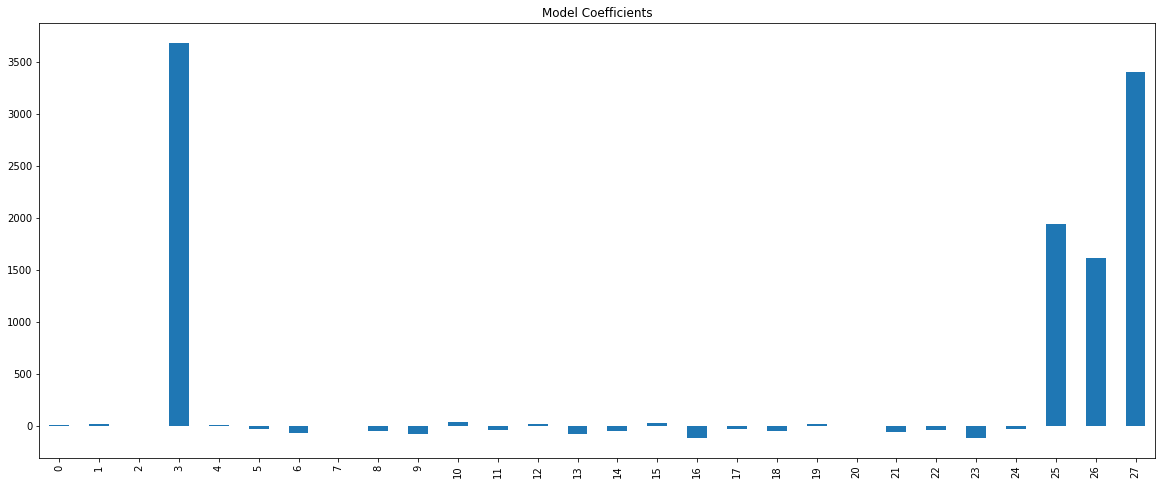

In [ ]:
coef1 = pd.Series(reg.coef_[0])
coef1.plot(kind='bar', title='Model Coefficients')

####We can see very high feature importance for the three supermarket types and the item MRP.

#### Applying Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha = 0.05, normalize = True)
ridge.fit(X_train, y_train)

Ridge(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=True, random_state=None, solver='auto', tol=0.001)

####Predicting the results of the test set

In [ ]:
y_pred_ridge = ridge.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

mean_squared_error = mean_squared_error(y_test, y_pred_ridge)
root_mean_squared_error = np.round(sqrt(mean_squared_error), 2)

print("For the Ridge Regression model: ")
print("The root mean squared error is : {}".format(root_mean_squared_error))

For the Ridge Regression model: 
The root mean squared error is : 1125.01


#### Applying polynomial regression

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree = 2)
X_poly_train = poly_reg.fit_transform(X_train)
poly_reg.fit(X_poly_train, y_train)
pol_lin_reg = LinearRegression()
pol_lin_reg.fit(X_poly_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#### Predicting for test set

In [ ]:
X_poly_test = poly_reg.fit_transform(X_test)
y_pred_poly = pol_lin_reg.predict(X_poly_test)

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

mean_squared_error = mean_squared_error(y_test, y_pred_poly)
root_mean_squared_error = np.round(sqrt(mean_squared_error), 2)

print("For the Polynomial Regression model: ")
print("The root mean squared error is : {}".format(root_mean_squared_error))

For the Polynomial Regression model: 
The root mean squared error is : 1084.36


#### Applying Random Forest 

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

#### Predicting for test set

In [ ]:
y_pred_rf = rf.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

mean_squared_error = mean_squared_error(y_test, y_pred_rf)
root_mean_squared_error = np.round(sqrt(mean_squared_error), 2)

print("For the Random Forest Regression model: ")
print("The root mean squared error is : {}".format(root_mean_squared_error))

For the Random Forest Regression model: 
The root mean squared error is : 1139.99


####Applying XGBoost Regressor

In [ ]:
from xgboost.sklearn import XGBRegressor
XGB = XGBRegressor()
XGB.fit(X_train, y_train)

[08:05:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

####Predicting for test set

In [ ]:
y_pred_xgb = XGB.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

mean_squared_error = mean_squared_error(y_test, y_pred_xgb)
root_mean_squared_error = np.round(sqrt(mean_squared_error), 2)

print("For the XGBoost Regression model: ")
print("The root mean squared error is : {}".format(root_mean_squared_error))

For the XGBoost Regression model: 
The root mean squared error is : 1077.82


####Comparing the models

In [ ]:
acc = [['Linear Regression', 1120], ['Ridge Regression', 1125], ['Polynomial Regression', 1084], ['Random Forest Regression', 1139], ['XGBoost Regression', 1077]] 
  
# Create the pandas DataFrame 
model_acc = pd.DataFrame(acc, columns = ['Model', 'RMSE']).sort_values(ascending = True, by = 'RMSE')
model_acc

,Model,RMSE
4,XGBoost Regression,1077
2,Polynomial Regression,1084
0,Linear Regression,1120
1,Ridge Regression,1125
3,Random Forest Regression,1139


####The XGBoost regressor had the least RMSE value on the test set